<a href="https://colab.research.google.com/github/syKevinPeng/ExperimentResultAnalysis/blob/main/result_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
# process_result.py
from google.colab import drive
import os
import pathlib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [14]:

# mount google drive
drive.mount('/content/drive')

# path to directory
result_dir = "/content/drive/MyDrive/Research/VRExperiment"

# List all files in the folder
file_list = os.listdir(result_dir)
for file in file_list:
  print(file)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
3266_data.txt
158_data.txt
5477_data.txt


In [72]:
def analyze_staircase_with_alternating_three_rule(data):
    tuning_points = []
    no_count = 0  # Counter for consecutive "NO" responses
    yes_count = 0  # Counter for consecutive "YES" responses
    decreasing = True  # Flag to track if we are in the increasing or decreasing phase

    # Iterate over each trial in the data
    for i in range(len(data)):
        current_result = data['result'].iloc[i]

        if decreasing:
            # Count consecutive "NO"s in increasing phase
            if current_result == False:
                no_count += 1
            # After three "YES" responses, we mark a tuning point and switch to decreasing
            if no_count == 3:
                tuning_points.append(data['value'].iloc[i])
                no_count = 0  # Reset YES count
                decreasing = False  # Switch to decreasing phase

        else:
            # Count consecutive "YES"s in decreasing phase
            if current_result == True:
                yes_count += 1

            # After three "NO" responses, we mark a tuning point and switch to increasing
            if yes_count == 3:
                tuning_points.append(data['value'].iloc[i])
                yes_count = 0  # Reset NO count
                decreasing = True  # Switch to increasing phase

    # Calculate the threshold as the average of all tuning points
    threshold = sum(tuning_points) / len(tuning_points) if tuning_points else None

    return threshold, tuning_points


In [73]:
def plot_staircase_with_alternating_three_rule(data, tuning_points = None):
    # x axis is the number of responses
    # y axis is the illusion value
    # when result is yes, mark the dot to green; when the result is no, mark the dot to red
    # if tuning_points is not none, make the turning points to be triangle

    # Initialize plot
    plt.figure(figsize=(10, 6))

    # Plot each response
    for i, row in data.iterrows():
        x = i  # x-axis is the response number
        y = row['value']  # y-axis is the illusion value

        # Set color based on the result (YES: green, NO: red)
        color = 'green' if row['result'] else 'red'

        # Plot each point as a circle
        plt.scatter(x, y, color=color, marker='o', label='YES' if color == 'green' else 'NO')

    # Highlight tuning points, if provided
    if tuning_points:
        for point in tuning_points:
            index = data[data['value'] == point].index[0]  # Find index of each tuning point
            plt.scatter(index, point, color='blue', marker='^', s=100, label='Tuning Point')

    # Add labels and title
    plt.xlabel("Response Number")
    plt.ylabel("Illusion Value")
    plt.title("Staircase Plot with Alternating Three Rule")
    plt.legend(['YES', 'NO', 'Tuning Point'])
    plt.grid(True)
    plt.show()



In [74]:
def process_one_result(file_name):
    print(f'Processing: {file_name}')
    # read file
    file_path = os.path.join(result_dir, file_name)
    with open(file_path, 'r') as file:
        lines = file.readlines()
    UID = lines[0].split(":")[1].strip()
    # find the last occurance of line UID
    last_index = len(lines) - 1
    for i in range(len(lines) - 1, -1, -1):
        if lines[i].startswith("UID:"):
            last_index = i
            break
    print(f'starting from line: {last_index}')
    # start from last_index
    lines = lines[last_index:]
    # remove first two lines (UID and text)
    result = lines[2:]
    # conver to df
    df = pd.DataFrame(result, columns=["result"])
    # split by comma, column name: experiment type, value, result
    df[["experiment", "value", "result"]] = df["result"].str.split(",", expand=True)
    # split experiment column to scene and illusion type
    df[["scene", "illusion"]] = df["experiment"].str.split(" ", expand=True)
    # drop experiment column
    df = df.drop(columns=["experiment"])
    # remove "\n" from the result column
    df["result"] = df["result"].str.replace("\n", "")
    # rearrange column order: scene, illusion, value, result
    df = df[["scene", "illusion", "value", "result"]]
    # make value column to float type
    df["value"] = df["value"].astype(float)

    # illusion Pattern:
    illusion_patns = df["illusion"].unique()
    print(f'illusion patterns: {illusion_patns}')
    # convert result column to bool
    # Stationary scene
    stationary_scene = df[df["scene"] == "Stationary"]
    # illusion scene
    moving_scene = df[df["scene"] == "Moving"]
    if stationary_scene.empty:
        print("Stationary scene not found")
        return
    if moving_scene.empty:
        print("Moving scene not found")
        return

    # For this phycophysics experiment, we used staircase method, where we need
    # to find the tunning point and calculate the average of the turning point to determine the threshold
    for illusion_pattern in illusion_patns:
      illusion_pattern_data = stationary_scene[stationary_scene["illusion"] == illusion_pattern]
      if illusion_pattern_data.empty:
        print(f"Illusion pattern {illusion_pattern} not found")
        continue
      moving_scene_threshold, moving_scene_tuning_points = analyze_staircase_with_alternating_three_rule(illusion_pattern_data)
      print(f'Moving scene {illusion_pattern} threshold: {moving_scene_threshold}')
      print(f'Moving scene {illusion_pattern} tuning points: {moving_scene_tuning_points}')
      plot_staircase_with_alternating_three_rule(illusion_pattern_data, moving_scene_tuning_points)





Processing: 3266_data.txt
starting from line: 0
illusion patterns: ['OuchiColor' 'OuchiLength' 'WheelColor' 'WheelLength']
Moving scene OuchiColor threshold: None
Moving scene OuchiColor tuning points: []


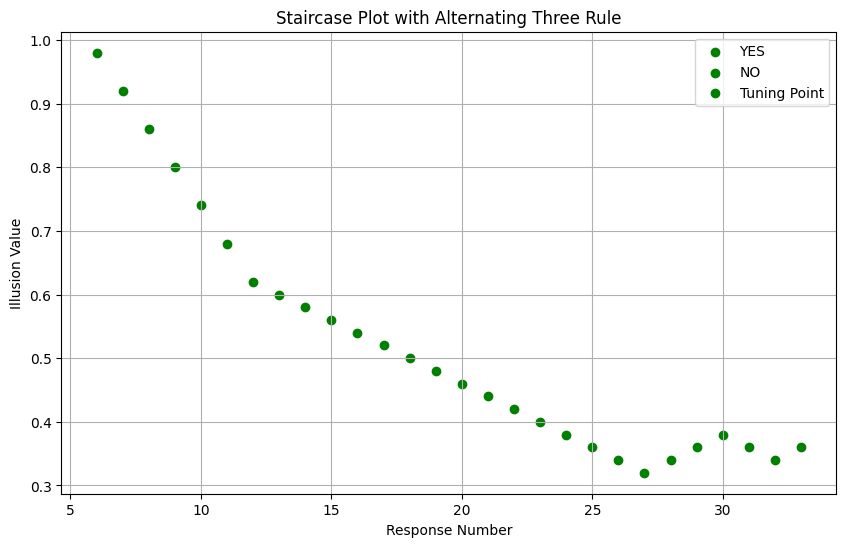

Moving scene OuchiLength threshold: None
Moving scene OuchiLength tuning points: []


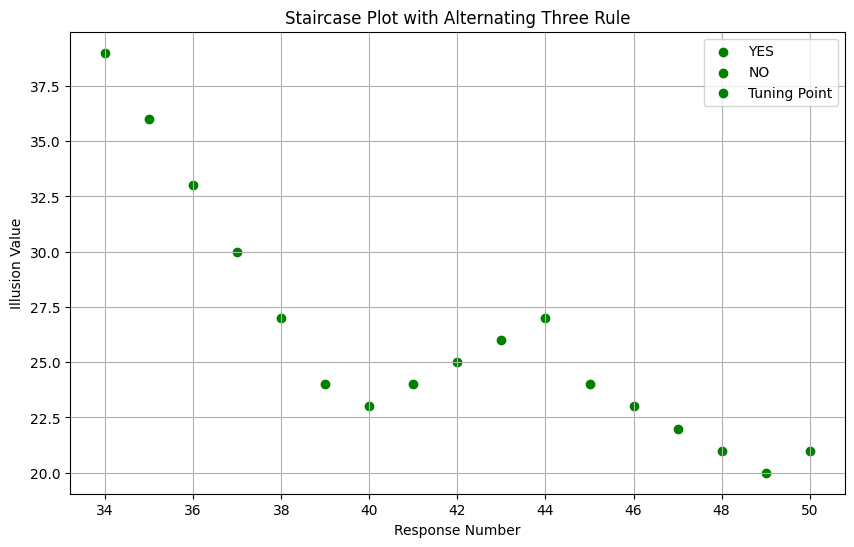

Moving scene WheelColor threshold: None
Moving scene WheelColor tuning points: []


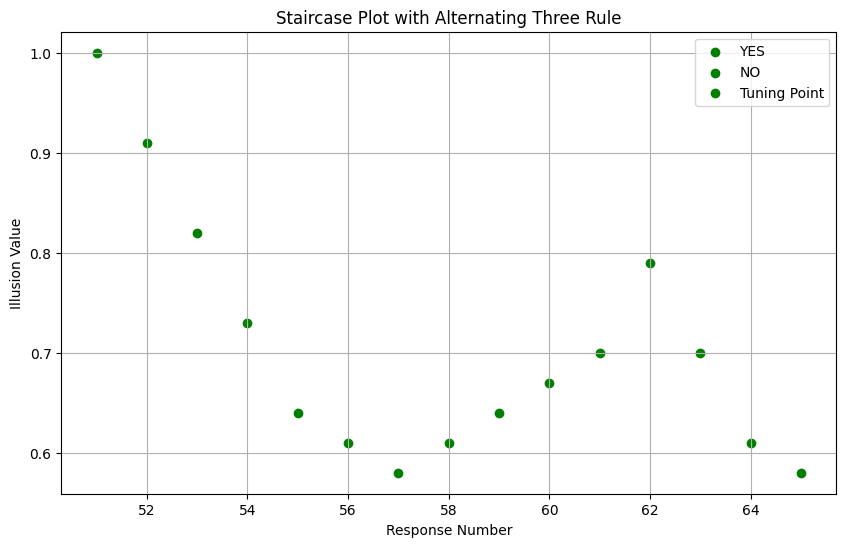

Moving scene WheelLength threshold: None
Moving scene WheelLength tuning points: []


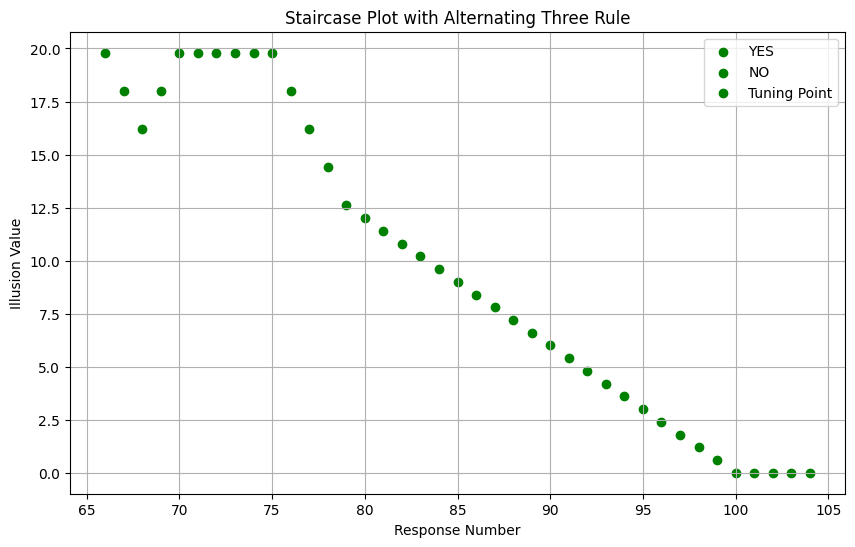

In [75]:
for file in file_list:
  process_one_result(file)
  break